In [1]:
import numpy as np
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import compare_ssim
from scipy.stats import pearsonr
from skimage import color
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
%matplotlib inline 


In [171]:
def gini(array):
    array = np.array(array, dtype=np.float64)
    array = np.abs(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

def jaccard(ori_map, adv_map, k):
    mask1 = ori_map > np.percentile(ori_map, k) #取出指定容器內幾%的值(pr值)
    mask2 = adv_map > np.percentile(adv_map, k) #取出指定容器內幾%的值(pr值)
    test1 = set_matrix[mask1]
    test2 = set_matrix[mask2]
    set_1 = set(test1)
    set_2 = set(test2)

    inter = set_1.intersection(set_2)
    union = set_1.union(set_2)
    return len(inter) / len(union)

def heatmap_to_image(heatmap):
    img = heatmap / np.max(np.abs(heatmap))  # divide by maximum
    img = np.maximum(-1, img)
    img = np.minimum(1, img) * 0.5  # clamp to -1 and divide by two -> range [-0.5, 0.5]
    img = img + 0.5
    return img

def show_result(img):
    img = heatmap_to_image(img)
    im = Image.fromarray(np.uint8(img*255))
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 3
    plt.axis('off')
    plt.imshow(im,cmap='seismic',norm=mpl.colors.NoNorm())
    
def compute_image_metric(exp, n, dirt):
    PSNR_list = []
    MSE_list = []
    SSIM_list = []
    PCCS_list = []
    for i in range(1,n+1):
        im_orig_path = dirt + 'ori_img/' + str(i) + '_ori_img.npy'
        im_adv_path = dirt + exp + '_adv_img/' + str(i) + '_adv_img.npy'
        im_orig = np.load(im_orig_path)
        im_adv = np.load(im_adv_path)

        img1 = im_orig 
        img2 = im_adv
        img1_gray = color.rgb2gray(img1)
        img2_gray = color.rgb2gray(img2)
        
        PSNR = peak_signal_noise_ratio(img1, img2)
        MSE = mean_squared_error(img1, img2)
        SSIM = structural_similarity(img1, img2, multichannel=True)
        PCCS = pearsonr(img1_gray.flatten(),img2_gray.flatten())
        
        PSNR_list.append(PSNR)
        MSE_list.append(MSE)
        SSIM_list.append(SSIM)
        PCCS_list.append(PCCS)

    return PSNR_list, MSE_list, SSIM_list, PCCS_list, im_orig, im_adv

def compute_map_metric(exp, n, dirt):
    PSNR_list = []
    MSE_list = []
    SSIM_list = []
    PCCS_list = []
    GINI_list = []
    jaccard_list = []
    adv_gini_list = []
    ori_gini_list = []
    for i in range(1,n+1):
        im_orig_path = dirt + exp + '_ori_map/' + str(i) + '_ori_map.npy'
        im_adv_path = dirt + exp + '_adv_map/' + str(i) + '_adv_map.npy'
        im_orig = np.load(im_orig_path)
        im_adv = np.load(im_adv_path)

        img1 = im_orig 
        img2 = im_adv
        img1_gray = color.rgb2gray(img1)
        img2_gray = color.rgb2gray(img2)

        PSNR = peak_signal_noise_ratio(img1, img2)
        MSE = mean_squared_error(img1, img2)
        SSIM = structural_similarity(img1, img2, multichannel=True)
        PCCS = pearsonr(img1_gray.flatten(),img2_gray.flatten())
        GINI_diff = np.abs(gini(img1_gray.flatten()) - gini(img2_gray.flatten()))
        jaccard_index = jaccard(im_orig, im_adv, 90)
        PSNR_list.append(PSNR)
        MSE_list.append(MSE)
        SSIM_list.append(SSIM)
        PCCS_list.append(PCCS[0])
        GINI_list.append(GINI_diff)
        jaccard_list.append(jaccard_index)
        ori_gini_list.append(gini(img1_gray.flatten()))
        adv_gini_list.append(gini(img2_gray.flatten()))
    return PSNR_list, MSE_list, SSIM_list, PCCS_list, GINI_list, ori_gini_list, adv_gini_list, jaccard_list, im_orig, im_adv


def compute_image_metric_show(exp, nth, dirt):
    PSNR_list = []
    MSE_list = []
    SSIM_list = []

    im_orig_path = dirt + 'ori_img/' + str(nth) + '_ori_img.npy'
    im_adv_path = dirt + exp + '_adv_img/' + str(nth) + '_adv_img.npy'
    im_orig = np.load(im_orig_path)
    im_adv = np.load(im_adv_path)

    img1 = im_orig 
    img2 = im_adv

    PSNR = peak_signal_noise_ratio(img1, img2)
    MSE = mean_squared_error(img1, img2)
    SSIM = structural_similarity(img1, img2, multichannel=True)

    PSNR_list.append(PSNR)
    MSE_list.append(MSE)
    SSIM_list.append(SSIM)

    return PSNR_list, MSE_list, SSIM_list, im_orig, im_adv

def compute_map_metric_show(exp, nth, dirt):
    PSNR_list = []
    MSE_list = []
    SSIM_list = []
    PCCS_list = []
    GINI_list = []
    jaccard_list = []
    
    im_orig_path = dirt + exp + '_ori_map/' + str(nth) + '_ori_map.npy'
    im_adv_path = dirt + exp + '_adv_map/' + str(nth) + '_adv_map.npy'
    im_orig = np.load(im_orig_path)
    im_adv = np.load(im_adv_path)

    img1 = im_orig 
    img2 = im_adv
    img1_gray = color.rgb2gray(img1)
    img2_gray = color.rgb2gray(img2)

    PSNR = peak_signal_noise_ratio(img1, img2)
    MSE = mean_squared_error(img1, img2)
    SSIM = structural_similarity(img1, img2, multichannel=True)
    PCCS = pearsonr(img1_gray.flatten(),img2_gray.flatten())
    GINI_diff = np.abs(gini(img1_gray.flatten()) - gini(img2_gray.flatten()))
    jaccard_index = jaccard(im_orig, im_adv, 90)
    
    PSNR_list.append(PSNR)
    MSE_list.append(MSE)
    SSIM_list.append(SSIM)
    PCCS_list.append(PCCS[0])
    GINI_list.append(GINI_diff)
    jaccard_list.append(jaccard_index)

    return PSNR_list, MSE_list, SSIM_list, PCCS_list, GINI_list, jaccard_list, im_orig, im_adv

#---------------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:235: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:236: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


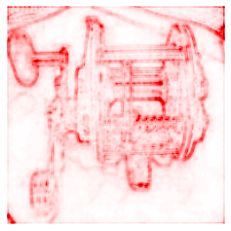

In [38]:
# 檢查輸出的圖片有沒有問題
PSNR_lrp, MSE_lrp, SSIM_lrp, ori_img, adv_img = compute_image_metric2_oripaper("lrp",2)
PSNR_lrp_map, MSE_lrp_map, SSIM_lrp_map, PCCS_lrp_map, GINI_lrp_map, jaccard_map, ori_map, adv_map = compute_map_metric2_oripaper("lrp",1)
show_result(ori_map)

In [172]:
method_list = ['gradient', 'grad_times_input', 'integrated_grad', 'lrp', 'guided_backprop']
for m in method_list:
    PSNR_exp, MSE_exp, SSIM_exp, PCCS_exp, ori_img, adv_img = compute_image_metric(m,100,'img_data/')
    PSNR_exp_map, MSE_exp_map, SSIM_exp_map, PCCS_exp_map, GINI_exp_map, GINI_ori_map, GINI_adv_map, jaccard_map, ori_map, adv_map = compute_map_metric(m,100,'img_data/')
    print(m,'image')
    print('PSNR', 'mean:', np.mean(PSNR_exp), 'std:', np.std(PSNR_exp))
    print('MSE', 'mean:', np.mean(MSE_exp), 'std:', np.std(MSE_exp))
    print('SSIM', 'mean:', np.mean(SSIM_exp), 'std:', np.std(SSIM_exp))
    print('PCCS', 'mean:', np.mean(PCCS_exp), 'std:', np.std(PCCS_exp))
    print(m,'map')
    print('PSNR', 'mean:', np.mean(PSNR_exp_map), 'std:', np.std(PSNR_exp_map))
    print('MSE', 'mean:', np.mean(MSE_exp_map), 'std:', np.std(MSE_exp_map))
    print('SSIM', 'mean:', np.mean(SSIM_exp_map), 'std:', np.std(SSIM_exp_map))
    print('PCCS', 'mean:', np.mean(PCCS_exp_map), 'std:', np.std(PCCS_exp_map))
    print('GINI', 'mean:', np.mean(GINI_exp_map), 'std:', np.std(GINI_exp_map))
    print('GINI_ori', 'mean:', np.mean(GINI_ori_map), 'std:', np.std(GINI_ori_map))
    print('GINI_adv', 'mean:', np.mean(GINI_adv_map), 'std:', np.std(GINI_adv_map))
    print('JACCARD', 'mean:', np.mean(jaccard_map), 'std:', np.std(jaccard_map))
    print('--------------------------------------------')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


gradient image
PSNR mean: 49.91157670874958 std: 3.3171908927478846
MSE mean: 1.3364695026668596e-05 std: 1.0035762692444594e-05
SSIM mean: 0.9986279924366817 std: 0.0008021166828093685
PCCS mean: 0.4999428729621884 std: 0.49994287991007963
gradient map
PSNR mean: 84.70184922399159 std: 1.8859012224772045
MSE mean: 3.7003173149838712e-09 std: 1.5242014055786893e-09
SSIM mean: 0.9999923200715604 std: 3.3760616515127794e-06
PCCS mean: 0.10660598615890873 std: 0.1066051486552805
GINI mean: 0.24429597651745918 std: 0.08438803975301579
GINI_ori mean: 0.4696880816592461 std: 0.04802444284435222
GINI_adv mean: 0.7127260651689309 std: 0.08149514215092592
JACCARD mean: 0.1504910086786074 std: 0.052900301386516
--------------------------------------------
grad_times_input image
PSNR mean: 49.20091757276241 std: 3.031893097512145
MSE mean: 1.5057452449624356e-05 std: 1.0206220723984504e-05
SSIM mean: 0.9984628288158213 std: 0.0007954613872791456
PCCS mean: 0.4999342820703271 std: 0.49993429111037

## Metric of Explanations can be manipulated and geometry is to blame

In [173]:
method_list = ['gradient', 'grad_times_input', 'integrated_grad', 'lrp', 'guided_backprop']
for m in method_list:
    PSNR_exp, MSE_exp, SSIM_exp, PCCS_exp, ori_img, adv_img = compute_image_metric(m,100,'img_data_oripaper/')
    PSNR_exp_map, MSE_exp_map, SSIM_exp_map, PCCS_exp_map, GINI_exp_map, GINI_ori_map, GINI_adv_map, jaccard_map, ori_map, adv_map = compute_map_metric(m,100,'img_data_oripaper/')
    print(m,'image')
    print('PSNR', 'mean:', np.mean(PSNR_exp), 'std:', np.std(PSNR_exp))
    print('MSE', 'mean:', np.mean(MSE_exp), 'std:', np.std(MSE_exp))
    print('SSIM', 'mean:', np.mean(SSIM_exp), 'std:', np.std(SSIM_exp))
    print('PCCS', 'mean:', np.mean(PCCS_exp), 'std:', np.std(PCCS_exp))
    print(m,'map')
    print('PSNR', 'mean:', np.mean(PSNR_exp_map), 'std:', np.std(PSNR_exp_map))
    print('MSE', 'mean:', np.mean(MSE_exp_map), 'std:', np.std(MSE_exp_map))
    print('SSIM', 'mean:', np.mean(SSIM_exp_map), 'std:', np.std(SSIM_exp_map))
    print('PCCS', 'mean:', np.mean(PCCS_exp_map), 'std:', np.std(PCCS_exp_map))
    print('GINI', 'mean:', np.mean(GINI_exp_map), 'std:', np.std(GINI_exp_map))
    print('GINI_ori', 'mean:', np.mean(GINI_ori_map), 'std:', np.std(GINI_ori_map))
    print('GINI_adv', 'mean:', np.mean(GINI_adv_map), 'std:', np.std(GINI_adv_map))
    print('JACCARD', 'mean:', np.mean(jaccard_map), 'std:', np.std(jaccard_map))
    print('--------------------------------------------')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


gradient image
PSNR mean: 47.97555890359098 std: 1.7762391044826702
MSE mean: 1.7231169213599297e-05 std: 6.51641325327123e-06
SSIM mean: 0.9981781991562587 std: 0.0005048001405410667
PCCS mean: 0.4999275537799626 std: 0.4999275578268803
gradient map
PSNR mean: 91.98224496537816 std: 1.2631320037516918
MSE mean: 6.629075986638627e-10 std: 2.164492549957263e-10
SSIM mean: 0.9999989900244064 std: 4.3116993518569614e-07
PCCS mean: 0.17123507185997702 std: 0.10129611171092578
GINI mean: 0.08173126474169796 std: 0.053998027329775856
GINI_ori mean: 0.4696880816592461 std: 0.04802444284435222
GINI_adv mean: 0.4001605114118902 std: 0.05193516081913665
JACCARD mean: 0.10533432623741583 std: 0.043323142112350756
--------------------------------------------
grad_times_input image
PSNR mean: 47.570701034601626 std: 1.8406600575024552
MSE mean: 1.9044801173422566e-05 std: 7.606710687608706e-06
SSIM mean: 0.9980224907294318 std: 0.000547547365814171
PCCS mean: 0.49992157928704617 std: 0.499921583662

## early stopping

In [150]:
method_list = ['gradient', 'grad_times_input', 'integrated_grad']
for m in method_list:
    PSNR_exp, MSE_exp, SSIM_exp, ori_img, adv_img = compute_image_metric(m,100,'img_data_500/')
    PSNR_exp_map, MSE_exp_map, SSIM_exp_map, PCCS_exp_map, GINI_exp_map, GINI_ori_map, GINI_adv_map, jaccard_map, ori_map, adv_map = compute_map_metric(m,100,'img_data_500/')
    print(m,'image')
    print('PSNR', 'mean:', np.mean(PSNR_exp), 'std:', np.std(PSNR_exp))
    print('MSE', 'mean:', np.mean(MSE_exp), 'std:', np.std(MSE_exp))
    print('SSIM', 'mean:', np.mean(SSIM_exp), 'std:', np.std(SSIM_exp))
    print(m,'map')
    print('PSNR', 'mean:', np.mean(PSNR_exp_map), 'std:', np.std(PSNR_exp_map))
    print('MSE', 'mean:', np.mean(MSE_exp_map), 'std:', np.std(MSE_exp_map))
    print('SSIM', 'mean:', np.mean(SSIM_exp_map), 'std:', np.std(SSIM_exp_map))
    print('PCCS', 'mean:', np.mean(PCCS_exp_map), 'std:', np.std(PCCS_exp_map))
    print('GINI', 'mean:', np.mean(GINI_exp_map), 'std:', np.std(GINI_exp_map))
    print('GINI_ori', 'mean:', np.mean(GINI_ori_map), 'std:', np.std(GINI_ori_map))
    print('GINI_adv', 'mean:', np.mean(GINI_adv_map), 'std:', np.std(GINI_adv_map))
    print('JACCARD', 'mean:', np.mean(jaccard_map), 'std:', np.std(jaccard_map))
    print('--------------------------------------------')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


gradient image
PSNR mean: 58.496173837757894 std: 3.869431108556394
MSE mean: 2.035962382502848e-06 std: 1.7717667497816267e-06
SSIM mean: 0.9997529421391798 std: 0.0002090914113309884
gradient map
PSNR mean: 89.32120937124178 std: 3.4753242522712
MSE mean: 1.5532327445801375e-09 std: 1.0946127487148916e-09
SSIM mean: 0.9999970470992379 std: 2.2395600777423596e-06
PCCS mean: 0.34625349881373846 std: 0.19781818658822126
GINI mean: 0.11488961983296779 std: 0.07858422373765127
GINI_ori mean: 0.4696880816592461 std: 0.04802444284435222
GINI_adv mean: 0.5723567254904168 std: 0.09097183496399898
JACCARD mean: 0.2646683072026172 std: 0.09225370916112353
--------------------------------------------
grad_times_input image
PSNR mean: 57.94123224408451 std: 3.6672374498294067
MSE mean: 2.217483013833114e-06 std: 1.766645299460988e-06
SSIM mean: 0.9997313868864051 std: 0.00021275645500748127
grad_times_input map
PSNR mean: 88.05962217255596 std: 3.3912911425360655
MSE mean: 2.043049175140578e-09 s

### epoch 比較

### 原map與擾動map比較

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


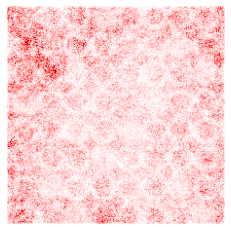

In [169]:
PSNR_lrp, MSE_lrp, SSIM_lrp, ori_img, adv_img = compute_image_metric_show("gradient",121,'img_data_oripaper/')
PSNR_lrp_map, MSE_lrp_map, SSIM_lrp_map, PCCS_lrp_map, GINI_lrp_map, jaccard_lrp_map, ori_map, adv_map = compute_map_metric_show("gradient",121,'img_data_oripaper/')
show_result(adv_map)

In [177]:
import torch
from src.nn.utils import get_center_attack_matrix


no display found. Using non-interactive Agg backend


In [239]:
#'img_data_oripaper/' 'img_data/'
def compute_map_metric_target(exp, n, dirt):
    target_mse = []
    target_ssim = []
    for i in range(1,n+1):
        im_orig_path = dirt + exp + '_ori_map/' + str(i) + '_ori_map.npy'
        im_adv_path = dirt + exp + '_adv_map/' + str(i) + '_adv_map.npy'
        im_orig = np.load(im_orig_path)
        im_adv = np.load(im_adv_path)

        if dirt == 'img_data/':
            target_mtx_torch = torch.tensor(im_orig)
            target_mtx_torch = target_mtx_torch.view(1,224,224)
            target_mtx_torch = target_mtx_torch.float()     
            target_mtx = get_center_attack_matrix(200, 200, 35, target_mtx_torch, 224)
            MSE = mean_squared_error(im_adv, target_mtx)
            SSIM = structural_similarity(im_adv, target_mtx, multichannel=True)
        elif dirt == 'img_data_oripaper/':
            im_adv_path2 = dirt + exp + '_ori_map/' + str(i+1) + '_ori_map.npy'
            im_adv2 = np.load(im_adv_path2)
            MSE = mean_squared_error(im_adv, im_adv2)
            SSIM = structural_similarity(im_adv, im_adv2, multichannel=True)            
        target_mse.append(MSE)
        target_ssim.append(SSIM)
    if dirt == 'img_data/':
        return target_mse, target_ssim, im_adv, target_mtx
    elif dirt == 'img_data_oripaper/':
        return target_mse, target_ssim, im_adv, im_adv2



In [245]:
method_list = ['gradient', 'grad_times_input', 'integrated_grad', 'lrp', 'guided_backprop']
for m in method_list:
    mse, ssim, im_adv, target_mtx = compute_map_metric_target(m,100,'img_data/')
    print(m)
    print('MSE', 'mean:', np.mean(mse), 'std:', np.std(mse))
    print('SSIM', 'mean:', np.mean(ssim), 'std:', np.std(ssim))
    print('--------------------------------------------')

gradient
MSE mean: 2.0374665160926528e-07 std: 1.8619797791720497e-07
SSIM mean: 0.9994930826019783 std: 0.0004634165171859318
--------------------------------------------
grad_times_input
MSE mean: 4.4184125712683476e-07 std: 5.569107322765728e-07
SSIM mean: 0.9989020517650967 std: 0.0013784130783954642
--------------------------------------------
integrated_grad
MSE mean: 4.5421429881863105e-07 std: 5.846939269788475e-07
SSIM mean: 0.9988716488056884 std: 0.001445659757772745
--------------------------------------------
lrp
MSE mean: 2.099270844829932e-07 std: 3.961591840368212e-07
SSIM mean: 0.999478418295501 std: 0.0009801833622894878
--------------------------------------------
guided_backprop
MSE mean: 1.8840101346020467e-06 std: 3.862173386365636e-06
SSIM mean: 0.9954131895599057 std: 0.009124215615205954
--------------------------------------------


In [244]:
method_list = ['gradient', 'grad_times_input', 'integrated_grad', 'lrp', 'guided_backprop']
for m in method_list:
    mse, ssim, im_adv, target_mtx = compute_map_metric_target(m,100,'img_data_oripaper/')
    print(m)
    print('MSE', 'mean:', np.mean(mse), 'std:', np.std(mse))
    print('SSIM', 'mean:', np.mean(ssim), 'std:', np.std(ssim))
    print('--------------------------------------------')

gradient
MSE mean: 1.9858615502186954e-10 std: 6.366253076172499e-11
SSIM mean: 0.9999998432083862 std: 6.243956517325336e-08
--------------------------------------------
grad_times_input
MSE mean: 3.5805506005968105e-10 std: 1.5434471320501233e-10
SSIM mean: 0.9999996399984161 std: 1.984281348628996e-07
--------------------------------------------
integrated_grad
MSE mean: 2.9518474104318635e-10 std: 1.5270718095512354e-10
SSIM mean: 0.9999997192266177 std: 1.838700008017314e-07
--------------------------------------------
lrp
MSE mean: 1.2005591550757428e-10 std: 5.83765812726201e-11
SSIM mean: 0.9999998288821691 std: 8.798332216058215e-08
--------------------------------------------
guided_backprop
MSE mean: 9.544180192521557e-10 std: 7.334140160306559e-10
SSIM mean: 0.9999988554478239 std: 8.787770017636043e-07
--------------------------------------------


In [232]:
mse, ssim, im_adv, target_mtx = compute_map_metric_target('gradient',2,'img_data/')
print('MSE', 'mean:', np.mean(mse), 'std:', np.std(mse))
print('SSIM', 'mean:', np.mean(ssim), 'std:', np.std(ssim))

MSE mean: 1.2784003018215943e-07 std: 2.556110841160651e-08
SSIM mean: 0.9996819113163922 std: 6.355086971615576e-05


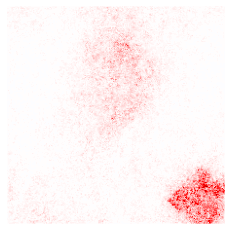

In [234]:
show_result(im_adv)

In [274]:
mse_ori, ssim_ori, im_adv_ori, target_mtx_ori = compute_map_metric_target('gradient',7,'img_data_oripaper/')
print('MSE', 'mean:', np.mean(mse_ori), 'std:', np.std(mse_ori))
print('SSIM', 'mean:', np.mean(ssim_ori), 'std:', np.std(ssim_ori))


MSE mean: 2.4016033913567623e-10 std: 8.453120391743909e-11
SSIM mean: 0.9999998007744298 std: 8.787315673923876e-08


In [186]:
im_orig_path = 'img_data/' + 'lrp' + '_ori_map/' + str(1) + '_ori_map.npy'
im_orig = np.load(im_orig_path)

0.5112037876637501

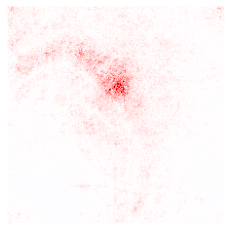

In [275]:
show_result(im_adv_ori)
gini(im_adv_ori.flatten())

0.6029538581428782

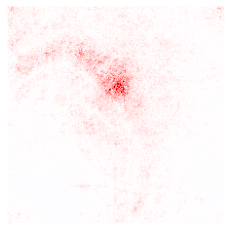

In [268]:
show_result(im_adv_ori)
gini(target_mtx_ori.flatten())

0.734305000522256

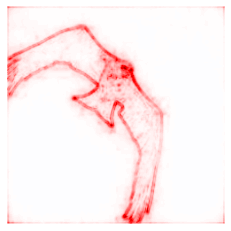

In [265]:
show_result(target_mtx_ori)
gini(target_mtx_ori.flatten())

In [190]:
target_mtx_torch = torch.tensor(im_orig)
target_mtx_torch = target_mtx_torch.view(1,224,224)
target_mtx_torch = target_mtx_torch.float()     

0.734305000522256